In [122]:
import pandas as pd
import numpy as np

from keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Dropout, MaxPooling1D, Bidirectional
from keras.layers import LSTM, Embedding
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping  

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df = pd.read_csv('clean_data_after_embedding.csv')

In [8]:
df.head(5)

,treated_question,target
0,"Do you have an adopted dog , how would you en...",0
1,Why does velocity affect time ? Does velocity...,0
2,How did Otto von Guericke used the Magdeburg h...,0
3,Can I convert montra helicon D to a mountain b...,0
4,"What is the dumbest , yet possibly true expla...",0


#### Prepare dataset for model

Tokenizer allows to vectorize a text corpus, by turning each text into a sequence of integers (each integer being the index of a token in a dictionary) where the coefficient for each token could be binary, based on word count, based on tf-idf. num_words: the maximum number of words to keep, based on word frequency. 


In [14]:
# --- Loading text and labels ----
x = df.treated_question.values
y = df.target.values

In [15]:
# tokenize
max_word_len = 90000   # the maximum number of words to keep, based on word frequency.
max_len = 60  # max number of words in a question to use

tokenizer = Tokenizer(num_words=max_word_len)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_len)  # Padding sequences 

word_index = tokenizer.word_index

print('Found {w} unique tokens in the texts.'.format(w=len(word_index)))
print('Shape of data tensor:', x.shape)
print('Shape of label:', y.shape)

Found 131447 unique tokens in the texts.
Shape of data tensor: (735502, 60)
Shape of label: (735502,)


#### Split dataset

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

#### Create model

Our model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 1 neurons since we have 2 labels in the output.

First, use GloVe word embeddings to convert text inputs to their numeric counterparts.

In [30]:
#### Embeddings
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')   
    embeddings_index = dict(get_coefs(*line.split(" ")) for line in open(file, encoding='utf8'))       
    return embeddings_index

embeddings_dictionary = load_embed("glove.840B.300d.txt")

In [33]:
len(word_index)

131447

In [43]:
embedding_matrix = np.zeros((max_word_len, 300))

for word, index in word_index.items():
    if index >= max_word_len:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None: 
        embedding_matrix[index] = embedding_vector

In [44]:
print('Found {} word vectors.'.format(len(embedding_matrix)))

Found 90000 word vectors.


In [45]:
embedding_matrix.shape

(90000, 300)

In [76]:
# define the model
inp    = Input(shape=(max_len,))
x      = Embedding(max_word_len, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)(inp) #distinct word length, embedding size, sentence length
x      = LSTM(128)(x)
x      = Dense(64, activation="relu")(x)
x      = Dropout(0.3)(x)
x      = Dense(32, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)

lstm_model  = Model(inputs=inp, outputs=x)

In [77]:
print(lstm_model.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 60, 300)           27000000  
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33 

In [79]:
# define f1 score
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [80]:
lstm_history = lstm_model.fit(x_train, y_train, batch_size=256, epochs=7, validation_data=(x_test, y_test))

Train on 588401 samples, validate on 147101 samples
Epoch 1/7
588401/588401 [==============================] - 797s 1ms/step - loss: 0.1778 - acc: 0.9283 - f1_m: 0.8389 - precision_m: 0.8557 - recall_m: 0.8301 - val_loss: 0.1401 - val_acc: 0.9436 - val_f1_m: 0.8756 - val_precision_m: 0.8875 - val_recall_m: 0.8659
Epoch 2/7
588401/588401 [==============================] - 770s 1ms/step - loss: 0.1294 - acc: 0.9482 - f1_m: 0.8862 - precision_m: 0.8956 - recall_m: 0.8797 - val_loss: 0.1266 - val_acc: 0.9493 - val_f1_m: 0.8915 - val_precision_m: 0.8780 - val_recall_m: 0.9072
Epoch 3/7
588401/588401 [==============================] - 833s 1ms/step - loss: 0.1122 - acc: 0.9551 - f1_m: 0.9016 - precision_m: 0.9072 - recall_m: 0.8983 - val_loss: 0.1194 - val_acc: 0.9527 - val_f1_m: 0.8952 - val_precision_m: 0.9122 - val_recall_m: 0.8804
Epoch 4/7
588401/588401 [==============================] - 967s 2ms/step - loss: 0.0984 - acc: 0.9606 - f1_m: 0.9142 - precision_m: 0.9171 - recall_m: 0.9132 -

### Word Level 1D CNN

In [87]:
# define the model
inp = Input(shape=(max_len,))
x   = Embedding(max_word_len, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)(inp) #distinct word length, embedding size, sentence length
x   = Dropout(0.3)(x)
x = Conv1D(32, 3, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D()(x)
x = Dropout(0.3)(x)
x = Conv1D(32, 3, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D()(x)
x = Conv1D(16, 3, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
x = Dense(200, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
cnn_model = Model(inputs=inp, outputs=predictions)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m,precision_m, recall_m]) # Adam, categorical_crossentropy
cnn_model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 60, 300)           27000000  
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 300)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 58, 32)            28832     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 29, 32)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 29, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 27, 32)            310

In [88]:
cnn_history = cnn_model.fit(x_train, y_train, batch_size=256, epochs=7, validation_data=(x_test, y_test))

Train on 588401 samples, validate on 147101 samples
Epoch 1/7
588401/588401 [==============================] - 198s 336us/step - loss: 0.2689 - acc: 0.8931 - f1_m: 0.7483 - precision_m: 0.8060 - recall_m: 0.7097 - val_loss: 0.2362 - val_acc: 0.9085 - val_f1_m: 0.8006 - val_precision_m: 0.8032 - val_recall_m: 0.8009
Epoch 2/7
588401/588401 [==============================] - 184s 313us/step - loss: 0.2405 - acc: 0.9055 - f1_m: 0.7828 - precision_m: 0.8317 - recall_m: 0.7428 - val_loss: 0.2189 - val_acc: 0.9139 - val_f1_m: 0.8013 - val_precision_m: 0.8541 - val_recall_m: 0.7573
Epoch 3/7
588401/588401 [==============================] - 203s 344us/step - loss: 0.2331 - acc: 0.9082 - f1_m: 0.7899 - precision_m: 0.8360 - recall_m: 0.7519 - val_loss: 0.2174 - val_acc: 0.9157 - val_f1_m: 0.8092 - val_precision_m: 0.8438 - val_recall_m: 0.7800
Epoch 4/7
588401/588401 [==============================] - 194s 330us/step - loss: 0.2291 - acc: 0.9099 - f1_m: 0.7934 - precision_m: 0.8404 - recall_m: 

###  Bidirectional LSTM + Attention 

In [120]:
from keras_self_attention import SeqSelfAttention

In [147]:
# define the model
inp = Input(shape=(max_len,))
x = Embedding(max_word_len, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)(inp) #distinct word length, embedding size, sentence length
x = Bidirectional(keras.layers.LSTM(units=64,return_sequences=True))(x)
x = SeqSelfAttention(attention_activation='sigmoid')(x)
x = Flatten()(x)
x = Dense(8, activation="sigmoid")(x)
x = Dense(1, activation="sigmoid")(x)
attention_model = Model(inputs=inp, outputs=x)
attention_model.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_43 (Embedding)     (None, 60, 300)           27000000  
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 60, 128)           186880    
_________________________________________________________________
seq_self_attention_16 (SeqSe (None, 60, 128)           8257      
_________________________________________________________________
flatten_8 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 61448     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 9  

In [149]:
attention_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m,precision_m, recall_m])
attention_history = attention_model.fit(x_train, y_train, batch_size=256, epochs=2, validation_data=(x_test, y_test))

Train on 588401 samples, validate on 147101 samples
Epoch 1/3
588401/588401 [==============================] - 2129s 4ms/step - loss: 0.1688 - acc: 0.9349 - f1_m: 0.8566 - precision_m: 0.8705 - recall_m: 0.8473 - val_loss: 0.1397 - val_acc: 0.9448 - val_f1_m: 0.8753 - val_precision_m: 0.9110 - val_recall_m: 0.8441
Epoch 2/3
588401/588401 [==============================] - 2075s 4ms/step - loss: 0.1281 - acc: 0.9493 - f1_m: 0.8884 - precision_m: 0.8997 - recall_m: 0.8802 - val_loss: 0.1265 - val_acc: 0.9501 - val_f1_m: 0.8882 - val_precision_m: 0.9164 - val_recall_m: 0.8635
Epoch 3/3
588401/588401 [==============================] - 1815s 3ms/step - loss: 0.1115 - acc: 0.9559 - f1_m: 0.9033 - precision_m: 0.9110 - recall_m: 0.8980 - val_loss: 0.1197 - val_acc: 0.9530 - val_f1_m: 0.8988 - val_precision_m: 0.8905 - val_recall_m: 0.9089


### Performance Comparison

Due to computational ability, we only conducted three epochs for Bidirectional RNN+Attention model. 

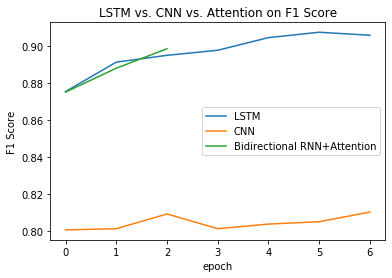

In [158]:
plt.plot(lstm_history.history['val_f1_m'])
plt.plot(cnn_history.history['val_f1_m'])
plt.plot(attention_history.history['val_f1_m'])

plt.title('LSTM vs. CNN vs. Attention on F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['LSTM','CNN', 'Bidirectional RNN+Attention'], loc='best')
plt.show()

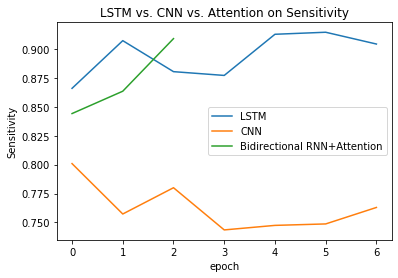

In [161]:
plt.plot(lstm_history.history['val_recall_m'])
plt.plot(cnn_history.history['val_recall_m'])
plt.plot(attention_history.history['val_recall_m'])

plt.title('LSTM vs. CNN vs. Attention on Sensitivity')
plt.ylabel('Sensitivity')
plt.xlabel('epoch')
plt.legend(['LSTM','CNN', 'Bidirectional RNN+Attention'], loc='best')
plt.show()

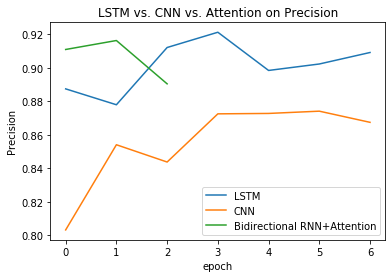

In [163]:
plt.plot(lstm_history.history['val_precision_m'])
plt.plot(cnn_history.history['val_precision_m'])
plt.plot(attention_history.history['val_precision_m'])

plt.title('LSTM vs. CNN vs. Attention on Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['LSTM','CNN', 'Bidirectional RNN+Attention'], loc='best')
plt.show()

It proves that Bidirectional RNN + Attention model is best on finding insincere questions. 